# Import Required Libraries

In [1]:
import dadaptation
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import random as rn
import wandb
import warnings
from tqdm import tqdm

#suppress warnings for cleaner output
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#set random seeds for reproducibility
torch.manual_seed(200)
np.random.seed(1)
rn.seed(400)


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Processed Data

In [2]:
data = pd.read_csv("processed_dat.csv")
data = data.iloc[:, 1:] #extract relevant columns
data = np.array(data).astype(float)


# Define Custom Pytorch Dataset

In [3]:
class ExpressionDataset(Dataset):
    def __init__(self):
        self.features = np.array(data)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        return features, features

dataset = ExpressionDataset()
datafeat = dataset.features
data1 = np.array (datafeat)


In [4]:
batch_size = 16

# Greedy Layerwise Pre-training

In [5]:
class Autoencoder(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim,optim_name,islatent=False):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
        )
        self.optimizer_name = optim_name
        
        #initialize weights for encoder and decoder
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        
        self.islatent = islatent
        
    #initialize weights using Xavier uniform distribution
    def init_weights(self, module):
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.constant_(module.bias, 0.0)
    def predict(self, batch):
        x,_ = batch
        if self.islatent == False:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
        else:
            encoded = self.encoder(x)
        
            for_sin = encoded[:, 0] / torch.sqrt(torch.square(encoded[:, 0]) + torch.square(encoded[:, 1]))
            for_cos = encoded[:, 1] / torch.sqrt(torch.square(encoded[:, 0]) + torch.square(encoded[:, 1]))
        return for_sin,for_cos
    
    def forward(self, batch):
        x,_ = batch
        if self.islatent == False:
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
        else:
            encoded = self.encoder(x)
        
            for_sin = encoded[:, 0] / torch.sqrt(torch.square(encoded[:, 0]) + torch.square(encoded[:, 1]))
            for_cos = encoded[:, 1] / torch.sqrt(torch.square(encoded[:, 0]) + torch.square(encoded[:, 1]))
    
            decoded = self.decoder(torch.stack([for_sin, for_cos], dim=1))
            
        return decoded

    def training_step(self, batch, batch_idx):
        x, _ = batch
        decoded = self(batch)
        activations = []
        activations.append(decoded.clone().detach()) 
        mse_loss = torch.mean((x - decoded) ** 2)
        
        self.log('mse_loss', mse_loss, on_epoch=True, prog_bar=True, logger=True)
        return mse_loss
        
    def configure_optimizers(self):
        if self.optimizer_name == 'SGD':
            optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.85)
        elif self.optimizer_name == 'Adam':
            optimizer = optim.Adam(self.parameters(), lr=0.001)
        elif self.optimizer_name == 'Dadapt':
            optimizer = dadaptation.DAdaptSGD(self.parameters(),lr=1.)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer_name}")
        return optimizer


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the first Autoencoder
data1_tensor = torch.tensor(data1, dtype=torch.float32)  
model1 = Autoencoder(input_dim=data1.shape[1], hidden_dim=2048,optim_name='SGD')
trainer1 = pl.Trainer(max_epochs=7)
trainer1.fit(model1, dataloader)

encoded_data1 = model1.encoder(data1_tensor).detach()

# Train the second Autoencoder
model2 = Autoencoder(input_dim=2048, hidden_dim=1024,optim_name='SGD')
dataset_encoded = TensorDataset(encoded_data1, encoded_data1)
dataloader_encoded = DataLoader(dataset_encoded, batch_size=batch_size, shuffle=True)

trainer2 = pl.Trainer(max_epochs=7)
trainer2.fit(model2, dataloader_encoded)

encoded_data2 = model2.encoder(encoded_data1).detach()

# Train the third Autoencoder
model3 = Autoencoder(input_dim=1024, hidden_dim=512,optim_name='Dadapt')
dataset_encoded2 = TensorDataset(encoded_data2, encoded_data2)
dataloader_encoded2 = DataLoader(dataset_encoded2, batch_size=batch_size, shuffle=True)

trainer3 = pl.Trainer(max_epochs=7)
trainer3.fit(model3, dataloader_encoded2)

encoded_data3 = model3.encoder(encoded_data2).detach()

# Train the fourth Autoencoder
model4 = Autoencoder(input_dim=512, hidden_dim=64,optim_name='Dadapt')
dataset_encoded3 = TensorDataset(encoded_data3, encoded_data3)
dataloader_encoded3 = DataLoader(dataset_encoded3, batch_size=batch_size, shuffle=True)

trainer4 = pl.Trainer(max_epochs=7)
trainer4.fit(model4, dataloader_encoded3)

encoded_data4 = model4.encoder(encoded_data3).detach()

# Train the fifth Autoencoder
model5 = Autoencoder(input_dim=64, hidden_dim=32,optim_name='Dadapt')
dataset_encoded4 = TensorDataset(encoded_data4, encoded_data4)
dataloader_encoded4 = DataLoader(dataset_encoded4, batch_size=batch_size, shuffle=True)

trainer5 = pl.Trainer(max_epochs=7)
trainer5.fit(model5, dataloader_encoded4)

encoded_data5 = model5.encoder(encoded_data4).detach()

# Train the sixth Autoencoder
model6 = Autoencoder(input_dim=32, hidden_dim=2,optim_name='Dadapt',islatent=True)
dataset_encoded5 = TensorDataset(encoded_data5, encoded_data5)
dataloader_encoded5 = DataLoader(dataset_encoded5, batch_size=batch_size, shuffle=True)

trainer6 = pl.Trainer(max_epochs=20)
trainer6.fit(model6, dataloader_encoded5)

test_loader_ = DataLoader(dataset_encoded5, batch_size=16
                          , shuffle=False)

#predict initial angular phases
with torch.no_grad():
    for batch in tqdm(test_loader_):
        sin, cos= model6.predict(batch)

pred_phases = torch.atan2(sin, cos) * 180. / math.pi #convert to degrees
angles = torch.where(pred_phases <= 0, 360 + pred_phases, pred_phases) # the range be (0-360)




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 4.8 M 
1 | decoder | Sequential | 4.8 M 
---------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params
38.307    Total estimated model params size (MB)


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s, loss=1.24, v_num=34, mse_loss_step=0.652, mse_loss_epoch=0.652]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s, loss=1.24, v_num=34, mse_loss_step=0.652, mse_loss_epoch=0.652]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.1 M 
1 | decoder | Sequential | 2.1 M 
---------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.790    Total estimated model params size (MB)



Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s, loss=1.07, v_num=35, mse_loss_step=0.705, mse_loss_epoch=0.705]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s, loss=1.07, v_num=35, mse_loss_step=0.705, mse_loss_epoch=0.705]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 524 K 
1 | decoder | Sequential | 525 K 
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.200     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 60.65it/s, loss=1.33, v_num=36, mse_loss_step=1.330, mse_loss_epoch=1.330]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s, loss=1.33, v_num=36, mse_loss_step=1.330, mse_loss_epoch=1.330]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 32.8 K
1 | decoder | Sequential | 33.3 K
---------------------------------------
66.1 K    Trainable params
0         Non-trainable params
66.1 K    Total params
0.264     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 26.54it/s, loss=1.38, v_num=37, mse_loss_step=1.380, mse_loss_epoch=1.380]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s, loss=1.38, v_num=37, mse_loss_step=1.380, mse_loss_epoch=1.380]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.1 K 
1 | decoder | Sequential | 2.1 K 
---------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 73.42it/s, loss=3.12, v_num=38, mse_loss_step=3.120, mse_loss_epoch=3.120] 

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 43.08it/s, loss=3.12, v_num=38, mse_loss_step=3.120, mse_loss_epoch=3.120]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 66    
1 | decoder | Sequential | 96    
---------------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 68.14it/s, loss=2.24, v_num=39, mse_loss_step=2.230, mse_loss_epoch=2.230] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s, loss=2.24, v_num=39, mse_loss_step=2.230, mse_loss_epoch=2.230]


100%|██████████| 1/1 [00:00<00:00, 651.39it/s]


In [6]:
print (angles)

tensor([358.0417, 357.9300, 159.8286, 150.7117, 201.6608, 172.8694, 254.8886,
          3.7851, 309.1533,  52.6974, 131.2830, 136.3634, 187.7247, 209.6694,
        242.2776, 198.3309])


# Find Initial Geometrical Information

In [7]:
import cosinor
amp = np.empty(data1.shape[1])
mesor = np.empty(data1.shape[1])
acrophase = np.empty(data1.shape[1])

#fit proteins to a cosine curve using inital phases
for i in range(datafeat.shape[1]):
 
        amp[i] = cosinor.fit_me(angles, data1[:,i],
                        n_components=1,period=360,plot=False,return_model=True)[2]
        mesor[i] = cosinor.fit_me(angles, data1[:,i],
                        n_components=1,period=360,plot=False,return_model=True)[3]
        acrophase[i] = cosinor.fit_me(angles, data1[:,i],
                        n_components=1,period=360,plot=False,return_model=True)[4]
amp = torch.tensor(amp,requires_grad=False)
mesor = torch.tensor(mesor,requires_grad=False)
acrophase = torch.tensor(acrophase,requires_grad=False)


In [8]:
bs = 16
pi = 3.14

# Fine tuning

In [9]:
class DeepNeuralNet(pl.LightningModule):
    def __init__(self, input_dim):
        super(DeepNeuralNet, self).__init__()
        
        self.input_dim = input_dim  #number of input features
        self.initialize_layers(input_dim) #initialize layers
        
        self.L = nn.Parameter(mesor)  
        self.alpha = nn.Parameter(acrophase)  
        self.A = nn.Parameter(amp)  
        self.period = nn.Parameter(torch.zeros(self.A.shape)+2*pi)
        self.outliers_per_protein = torch.zeros(self.input_dim)  # tracks number of times each protein is an outlier
        self.outlier_threshold = 2  # outlier detection threshold
        self.protein_epoch_threshold = 20  # remove proteins flagged as outliers for 20 epochs
        self.dataset = dataset
        self.outliers_per_sample = torch.zeros(len(self.dataset))  # track sample outliers
        self.sample_epoch_threshold = 20  


    def initialize_layers(self, input_dim):
        self.layer1 = nn.Sequential(nn.Linear(input_dim, 2048))
        self.layer2 = nn.Sequential(nn.Linear(2048, 1024))
        self.layer3 = nn.Sequential(nn.Linear(1024, 512))
        self.layer4 = nn.Sequential(nn.Linear(512, 64))
        self.layer5 = nn.Sequential(nn.Linear(64, 32))
        self.layer6 = nn.Sequential(nn.Linear(32, 2))

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0.0)

    def fit_loss(self, x, for_sin, for_cos):
        pi_on_180 = 0.017453292519943295 
        a = torch.atan2(for_sin, for_cos) * 180. / math.pi
        t = torch.where(a <= 0, 360 + a, a) * pi_on_180

        Y = self.L.unsqueeze(0) + self.A.unsqueeze(0) * torch.cos((2*pi/self.period)*t.unsqueeze(1) + self.alpha.unsqueeze(0))

        residuals1 = torch.abs(x - Y)
        # mean absolute error (per sample)
        fit_loss_per_sample = torch.mean(residuals1, axis=1)

        total_loss = torch.mean(fit_loss_per_sample)
        return total_loss

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # pass through layers
        layer1 = self.layer1(x)     
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)     
        layer4 = self.layer4(layer3)     
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)

        # calculate sine and cosine
        for_sin = layer6[:, 0] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))
        for_cos = layer6[:, 1] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))

        fit_loss = self.fit_loss(x, for_sin, for_cos)
        loss = 1e-1 * fit_loss
    
        self.log('fit_loss', fit_loss, on_epoch=True, prog_bar=True, logger=True)

        # calculate residuals and outliers
        self.calculate_outliers(x, for_sin, for_cos)

        return loss


    def calculate_outliers(self, x, for_sin, for_cos):
        
        a = torch.atan2(for_sin, for_cos) * 180. / math.pi
        t = torch.where(a <= 0, 360 + a, a) * 0.017453292519943295
        
        Y = self.L.unsqueeze(0) + self.A.unsqueeze(0) * torch.cos((2*pi/self.period)*t.unsqueeze(1) + self.alpha.unsqueeze(0))
        
        residuals = (x - Y)
        
        mean_residuals = torch.mean(residuals, axis=0)
        std_proteins = torch.std(mean_residuals)
        mean_proteins = torch.mean(mean_residuals)

        protein_outliers = torch.abs(mean_residuals - mean_proteins) > 2 * std_proteins
        self.outliers_per_protein += protein_outliers.int()
        
    def training_epoch_end(self, outputs):
        if self.current_epoch == 19:
            proteins_to_remove = torch.where(self.outliers_per_protein >= self.protein_epoch_threshold)[0]
            if len(proteins_to_remove) > 0:
                self.report_outlier_proteins(proteins_to_remove)


    def report_outlier_proteins(self, proteins_to_remove):
        low_amplitude_proteins = self.A[proteins_to_remove] < (self.A.mean()+self.A.std())
        self.final_proteins_to_remove = proteins_to_remove[low_amplitude_proteins]
        print(f"Final proteins to remove (based on amplitude threshold): {self.final_proteins_to_remove}")


    def predict(self, batch):
        x, _ = batch
        self.eval()
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)

        for_sin = (layer6[:, 0] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))).detach()
        for_cos = (layer6[:, 1] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))).detach()
        
        return for_sin, for_cos
 
    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=bs, shuffle=True, drop_last=True)

    def configure_optimizers(self):
        return dadaptation.DAdaptSGD(self.parameters(), lr=1.)

# Transfer weights
deep = DeepNeuralNet(input_dim=data1.shape[1])
deep.layer1.load_state_dict(model1.encoder.state_dict())
deep.layer2.load_state_dict(model2.encoder.state_dict())
deep.layer3.load_state_dict(model3.encoder.state_dict())
deep.layer4.load_state_dict(model4.encoder.state_dict())
deep.layer5.load_state_dict(model5.encoder.state_dict())
deep.layer6.load_state_dict(model6.encoder.state_dict())

trainer_da = pl.Trainer(max_epochs=20)
trainer_da.fit(deep)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layer1 | Sequential | 4.8 M 
1 | layer2 | Sequential | 2.1 M 
2 | layer3 | Sequential | 524 K 
3 | layer4 | Sequential | 32.8 K
4 | layer5 | Sequential | 2.1 K 
5 | layer6 | Sequential | 66    
--------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.822    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, loss=0.0672, v_num=40, fit_loss_step=0.659, fit_loss_epoch=0.659]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s, loss=0.0672, v_num=40, fit_loss_step=0.659, fit_loss_epoch=0.659]


In [10]:
excluded_proteins = deep.final_proteins_to_remove


In [11]:
#filter out the excluded proteins from data1 and the parameter tensors
keep_mask = np.ones(data1.shape[1], dtype=bool)
keep_mask[excluded_proteins] = False

filtered_data1 = data1[:, keep_mask]

filtered_amp = amp[keep_mask]
filtered_mesor = mesor[keep_mask]
filtered_alpha = acrophase[keep_mask]
class DeepNeuralNet(pl.LightningModule):
    def __init__(self, input_dim):
        super(DeepNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(input_dim, 512))
        self.layer2 = nn.Sequential(nn.Linear(512, 256))
        self.layer3 = nn.Sequential(nn.Linear(256, 128))
        self.layer4 = nn.Sequential(nn.Linear(128, 64))
        self.layer5 = nn.Sequential(nn.Linear(64, 32))
        self.layer6 = nn.Sequential(nn.Linear(32, 2))

        # set filtered parameters
        self.L = nn.Parameter(filtered_mesor)
        self.alpha = nn.Parameter(filtered_alpha)
        self.A = nn.Parameter(filtered_amp)
        self.period = nn.Parameter(torch.zeros(self.A.shape)+2*pi)
        
        # initialize weights
        self.apply(self.init_weights)
        self.dataset = dataset

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            init.xavier_uniform_(module.weight)
            init.constant_(module.bias, 0.0)

    def predict(self, batch):
        x, _ = batch
        self.eval()
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)

        for_sin = (layer6[:, 0] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))).detach()
        for_cos = (layer6[:, 1] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))).detach()
        
        return for_sin, for_cos

    def fit_loss(self, x, for_sin, for_cos):
        pi_on_180 = 0.017453292519943295
        a = torch.atan2(for_sin, for_cos) * 180. / math.pi
        t = torch.where(a <= 0, 360 + a, a) * pi_on_180
        Y = self.L.unsqueeze(0) + self.A.unsqueeze(0) * torch.cos(((2*pi)/self.period.unsqueeze(0))*t.unsqueeze(1) + self.alpha.unsqueeze(0))
        fit_loss_ = torch.mean(torch.mean(torch.abs(x - Y), axis=1))
        return fit_loss_

    def training_step(self, batch, batch_idx):
        x, _ = batch
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        layer5 = self.layer5(layer4)
        layer6 = self.layer6(layer5)

        for_sin = layer6[:, 0] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))
        for_cos = layer6[:, 1] / torch.sqrt(torch.square(layer6[:, 0]) + torch.square(layer6[:, 1]))

        fit_loss = self.fit_loss(x, for_sin, for_cos)
        loss = 1e-1 * fit_loss
        self.log('fit_loss', fit_loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def evaluate(self, dataset, batch_size=16):
        dataloader = DataLoader(dataset, batch_size=batch_size)
        angular_predictions = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating"):
                x, _ = batch
                x = x[:, ]
                sin, cos = self.predict((x, _))
                predicted_phases = torch.atan2(sin, cos) * 180. / math.pi
                angulars = torch.where(predicted_phases <= 0, 360 + predicted_phases, predicted_phases)
                angular_predictions.extend(angulars.cpu().numpy())
        
        return angular_predictions

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=bs, shuffle=True, drop_last=True)

    def configure_optimizers(self):
        return dadaptation.DAdaptSGD(self.parameters(), lr=1.)


filtered_deep = DeepNeuralNet(input_dim=filtered_data1.shape[1])
filtered_dataset = TensorDataset(
    torch.tensor(filtered_data1, dtype=torch.float32),
    torch.tensor(filtered_data1, dtype=torch.float32)
)
filtered_dataloader = DataLoader(filtered_dataset, batch_size=bs, shuffle=True)

trainer = pl.Trainer(max_epochs=200)
trainer.fit(filtered_deep, filtered_dataloader)

# Evaluation after training
angular_predictions = filtered_deep.evaluate(filtered_dataset)
print("Angular Predictions (0-360):", angular_predictions)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layer1 | Sequential | 1.2 M 
1 | layer2 | Sequential | 131 K 
2 | layer3 | Sequential | 32.9 K
3 | layer4 | Sequential | 8.3 K 
4 | layer5 | Sequential | 2.1 K 
5 | layer6 | Sequential | 66    
--------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.524     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s, loss=0.0648, v_num=41, fit_loss_step=0.648, fit_loss_epoch=0.648]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s, loss=0.0648, v_num=41, fit_loss_step=0.648, fit_loss_epoch=0.648]


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 44.53it/s]

Angular Predictions (0-360): [336.74487, 56.96363, 127.28432, 139.12025, 193.2656, 222.71689, 295.81207, 354.10675, 309.98816, 39.229473, 125.01475, 141.68784, 195.83324, 204.29784, 223.60829, 243.21133]


In [12]:
#labels
x_hours= np.arange(0,48, 3)%24

#our predictions
angulars1 = np.array(angular_predictions)*24/360


In [13]:
def tolplot(trueHr, predHr, add=True, col=1):
    plt.figure(figsize=(8, 8))  
    plt.rcParams.update({'font.size': 16})  

    predTimes = predHr 
    trueTimes = trueHr 
    hrerr = np.abs(predTimes - trueTimes)
    hrerr = np.minimum(hrerr, 24 - hrerr)
    hrsoff = np.linspace(0, 12, num=12)
    fracacc = np.array([100 * np.sum(np.abs(hrerr) > hrtol) / len(hrerr) for hrtol in hrsoff])

    if not add:
        col = 'blue'
        plt.plot(hrsoff, 100 - fracacc, color='blue', linewidth=4)
        plt.xlim(0, 12)
        plt.xlabel("Correct to within (hrs)", fontsize=30)
        plt.ylabel("% Correct", fontsize=30)
        plt.xticks(np.arange(0, 13, step=1), fontsize=18)  
        plt.yticks(np.arange(0, 101, step=10), fontsize=18)
        plt.grid(True, linestyle='--', alpha=0.5)
    else:
        plt.plot(hrsoff, 100 - fracacc, color=col, linewidth=5)
    plt.plot([0, 12], [0, 100], color='gray', linestyle='--', linewidth=2)

    norm_fracacc = (100 - fracacc) / 100
    norm_hrsoff = hrsoff / 12
    auc = np.sum(norm_fracacc[1:] * np.diff(norm_hrsoff))
    plt.text(7, 20, f"nAUC={auc:.2f}", fontsize=25, fontweight='bold')

    plt.legend(fontsize=14)
    plt.savefig("ours_wang.eps", bbox_inches='tight', dpi=300)  
    plt.show()

    return True


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

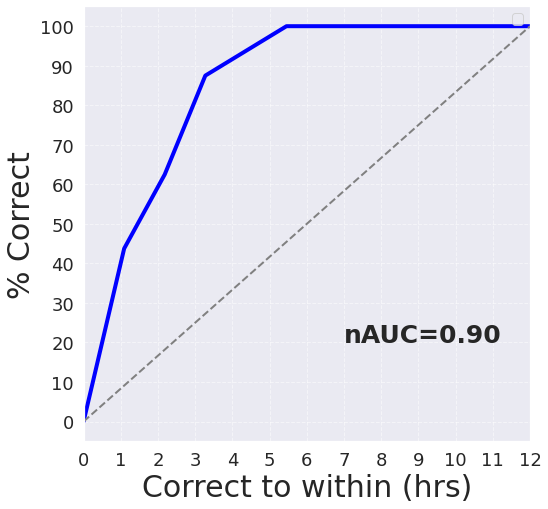

True

In [14]:
import seaborn as sns
sns.set()
tolplot(x_hours, angulars1, add=False, col=1)